In [1]:
import math
import numpy as np
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [3]:
def gen_train():
    for x_train, y_train in train_loader:
        I = x_train[0].numpy()
        K = np.zeros((1, 28, 28, 1), np.float32)
        I = (I / 255.0)
        K[0, ..., 0] = I.astype(np.float32)

        pts1 = np.float32([[(0, 0), (28, 0), (0, 28), (28, 28)]])

        rx = np.random.randint(0, 5, 1)[0]
        ry = np.random.randint(0, 5, 1)[0]
        pts2 = np.float32([[(5 + rx, ry), (20 + rx, ry), (0, 28), (28, 28)]])
        M = cv2.getPerspectiveTransform(pts2, pts1)
        Y = cv2.warpPerspective(K[0, :, :, 0], M, (28, 28))[None, ..., None]

        yield torch.from_numpy(Y), torch.from_numpy(K)

In [4]:
def gen_test():
    for x_test, y_test in test_loader:
        I = x_test[0].numpy()
        K = np.zeros((1, 28, 28, 1), np.float32)
        I = (I / 255.0)
        K[0, ..., 0] = I.astype(np.float32)

        pts1 = np.float32([[(0, 0), (28, 0), (0, 28), (28, 28)]])
        rx = np.random.randint(0, 5, 1)[0]
        ry = np.random.randint(0, 5, 1)[0]
        pts2 = np.float32([[(5 + rx, ry), (20 + rx, ry), (0, 28), (28, 28)]])
        M = cv2.getPerspectiveTransform(pts2, pts1)
        Y = cv2.warpPerspective(K[0, :, :, 0], M, (28, 28))[None, ..., None]

        yield torch.from_numpy(Y), torch.from_numpy(K)

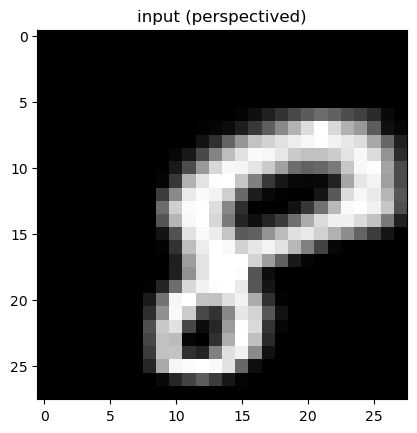

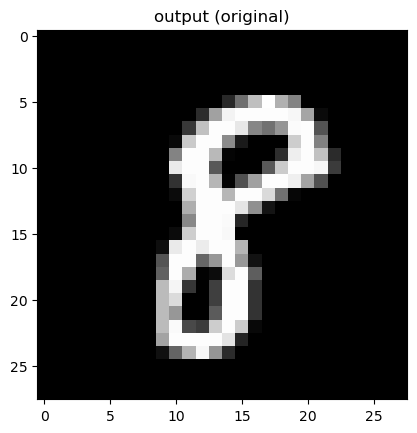

In [5]:
g_train = gen_train()
x_train, y_train = next(g_train)
plt.title('input (perspectived)')
plt.imshow(x_train[0, ..., 0], cmap='gray')
plt.figure()
plt.title('output (original)')
plt.imshow(y_train[0, ..., 0], cmap='gray')
plt.show()

In [6]:
import torch.nn as nn

class PerspectiveCorrectionCNN(nn.Module):
    def __init__(self):
        super(PerspectiveCorrectionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels set to 1 for grayscale images
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 784)  # Output size matches input size (28x28)

    def forward(self, x):
        x = torch.relu(self.conv1(x.permute(0, 3, 1, 2)))  # Transpose the dimensions
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid activation to output values in [0, 1]
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PerspectiveCorrectionCNN().to(device)

In [8]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

In [9]:
# Training loop
num_epochs = 1
print_every = 1000

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for i, (x_train, y_train) in enumerate(gen_train()):
        # Move input and target data to the GPU
        x_train, y_train = x_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        y_train = y_train.permute(0, 3, 1, 2).view(-1, 784)
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if (i + 1) % print_every == 0:
            average_loss = total_loss / print_every
            print(f'Epoch [{epoch + 1}/{num_epochs}], Iteration [{i + 1}/{len(train_loader)}], Loss: {average_loss:.10f}')
            total_loss = 0.0
            
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_test, y_test in gen_test():
            x_test, y_test = x_test.to(device), y_test.to(device)
            y_test = y_test.permute(0, 3, 1, 2).view(-1, 784)
            outputs = model(x_test)
            loss = criterion(outputs, y_test)
            total_loss += loss.item()

    average_loss = total_loss / len(test_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {average_loss:.10f}')

Epoch [1/1], Iteration [1000/60000], Loss: 0.0020584765
Epoch [1/1], Iteration [2000/60000], Loss: 0.0000014631
Epoch [1/1], Iteration [3000/60000], Loss: 0.0000014393
Epoch [1/1], Iteration [4000/60000], Loss: 0.0000014528
Epoch [1/1], Iteration [5000/60000], Loss: 0.0000014215
Epoch [1/1], Iteration [6000/60000], Loss: 0.0000013981
Epoch [1/1], Iteration [7000/60000], Loss: 0.0000013602
Epoch [1/1], Iteration [8000/60000], Loss: 0.0000012854
Epoch [1/1], Iteration [9000/60000], Loss: 0.0000012166
Epoch [1/1], Iteration [10000/60000], Loss: 0.0000011836
Epoch [1/1], Iteration [11000/60000], Loss: 0.0000011674
Epoch [1/1], Iteration [12000/60000], Loss: 0.0000011827
Epoch [1/1], Iteration [13000/60000], Loss: 0.0000011848
Epoch [1/1], Iteration [14000/60000], Loss: 0.0000011346
Epoch [1/1], Iteration [15000/60000], Loss: 0.0000011448
Epoch [1/1], Iteration [16000/60000], Loss: 0.0000011170
Epoch [1/1], Iteration [17000/60000], Loss: 0.0000011070
Epoch [1/1], Iteration [18000/60000], Lo

In [10]:
# Save the trained model if needed
torch.save(model.state_dict(), 'perspective_correction_model.pth')